In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossP = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    glossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    glossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, glossP, glossA, dlossA, glossQ, dlossQ

In [8]:
def model_opt(g_lossP, g_lossA, d_lossA, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_optP = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossP, var_list=g_vars)
        g_optA = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossA, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
    return g_optP, g_optA, d_optA

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_lossP, self.g_lossA, self.d_lossA, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_optP, self.g_optA, self.d_optA = model_opt(g_lossP=self.g_lossP, 
                                                          g_lossA=self.g_lossA, 
                                                          d_lossA=self.d_lossA, 
                                                          g_learning_rate=g_learning_rate, 
                                                          d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        glossP_batch, glossA_batch, dlossA_batch= [], [], []
        glossQ_batch, dlossQ_batch= [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, _, glossQ, dlossQ = sess.run([model.d_lossA, model.d_optA,
                                                  model.g_lossQ, model.d_lossQ],
                                                 feed_dict = {model.states: states, 
                                                              model.actions: actions,
                                                              model.targetQs: targetQs, 
                                                              model.rates: rates})
            glossA, _ = sess.run([model.g_lossA, model.g_optA], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            glossP, _ = sess.run([model.g_lossP, model.g_optP], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            glossP_batch.append(glossP)
            dlossA_batch.append(dlossA)
            glossA_batch.append(glossA)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'glossP:{:.4f}'.format(np.mean(glossP_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'glossA:{:.4f}'.format(np.mean(glossA_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 glossP:0.7149 dlossA:2.1780 glossA:1.3908 glossQ:1.0005 dlossQ:0.6405 exploreP:0.9985
Episode:1 meanR:18.0000 R:21.0000 rate:0.0420 glossP:0.7084 dlossA:2.1718 glossA:1.3898 glossQ:1.0005 dlossQ:0.6566 exploreP:0.9964
Episode:2 meanR:17.3333 R:16.0000 rate:0.0320 glossP:0.6999 dlossA:2.1604 glossA:1.3889 glossQ:1.0007 dlossQ:0.6765 exploreP:0.9949
Episode:3 meanR:17.7500 R:19.0000 rate:0.0380 glossP:0.7004 dlossA:2.1477 glossA:1.3871 glossQ:1.0000 dlossQ:0.6809 exploreP:0.9930
Episode:4 meanR:17.2000 R:15.0000 rate:0.0300 glossP:0.6900 dlossA:2.1454 glossA:1.3861 glossQ:1.0009 dlossQ:0.6772 exploreP:0.9915
Episode:5 meanR:20.1667 R:35.0000 rate:0.0700 glossP:0.6861 dlossA:2.1352 glossA:1.3853 glossQ:1.0011 dlossQ:0.7023 exploreP:0.9881
Episode:6 meanR:20.7143 R:24.0000 rate:0.0480 glossP:0.6782 dlossA:2.1242 glossA:1.3835 glossQ:1.0014 dlossQ:0.7188 exploreP:0.9857
Episode:7 meanR:19.3750 R:10.0000 rate:0.0200 glossP:0.6709 dlossA:2.1211 gl

Episode:62 meanR:25.0159 R:66.0000 rate:0.1320 glossP:0.2624 dlossA:1.7325 glossA:1.3050 glossQ:1.0455 dlossQ:0.8549 exploreP:0.8556
Episode:63 meanR:24.9375 R:20.0000 rate:0.0400 glossP:0.2502 dlossA:1.7307 glossA:1.3096 glossQ:1.0411 dlossQ:0.8587 exploreP:0.8540
Episode:64 meanR:25.5077 R:62.0000 rate:0.1240 glossP:0.2348 dlossA:1.7187 glossA:1.3058 glossQ:1.0428 dlossQ:0.8387 exploreP:0.8487
Episode:65 meanR:25.2879 R:11.0000 rate:0.0220 glossP:0.2302 dlossA:1.7068 glossA:1.2972 glossQ:1.0508 dlossQ:0.8569 exploreP:0.8478
Episode:66 meanR:25.1194 R:14.0000 rate:0.0280 glossP:0.2176 dlossA:1.6990 glossA:1.2944 glossQ:1.0446 dlossQ:0.8423 exploreP:0.8466
Episode:67 meanR:25.1324 R:26.0000 rate:0.0520 glossP:0.2210 dlossA:1.7007 glossA:1.2975 glossQ:1.0506 dlossQ:0.8625 exploreP:0.8445
Episode:68 meanR:25.9130 R:79.0000 rate:0.1580 glossP:0.1946 dlossA:1.6854 glossA:1.2948 glossQ:1.0505 dlossQ:0.8482 exploreP:0.8379
Episode:69 meanR:25.8143 R:19.0000 rate:0.0380 glossP:0.1826 dlossA:1

Episode:124 meanR:25.5900 R:13.0000 rate:0.0260 glossP:-0.5262 dlossA:1.2846 glossA:1.1343 glossQ:1.1713 dlossQ:0.8644 exploreP:0.7311
Episode:125 meanR:25.5100 R:9.0000 rate:0.0180 glossP:-0.5032 dlossA:1.2835 glossA:1.1299 glossQ:1.1519 dlossQ:0.8538 exploreP:0.7305
Episode:126 meanR:25.5300 R:19.0000 rate:0.0380 glossP:-0.5603 dlossA:1.2757 glossA:1.1304 glossQ:1.1451 dlossQ:0.8035 exploreP:0.7291
Episode:127 meanR:25.5900 R:25.0000 rate:0.0500 glossP:-0.5792 dlossA:1.2588 glossA:1.1162 glossQ:1.1536 dlossQ:0.8003 exploreP:0.7273
Episode:128 meanR:25.6000 R:13.0000 rate:0.0260 glossP:-0.5896 dlossA:1.2414 glossA:1.1011 glossQ:1.1560 dlossQ:0.8162 exploreP:0.7264
Episode:129 meanR:25.4700 R:23.0000 rate:0.0460 glossP:-0.6199 dlossA:1.2472 glossA:1.1122 glossQ:1.1450 dlossQ:0.7715 exploreP:0.7247
Episode:130 meanR:25.3600 R:13.0000 rate:0.0260 glossP:-0.6270 dlossA:1.2298 glossA:1.0972 glossQ:1.1528 dlossQ:0.7758 exploreP:0.7238
Episode:131 meanR:25.4100 R:21.0000 rate:0.0420 glossP:-

Episode:185 meanR:18.4800 R:19.0000 rate:0.0380 glossP:-1.1104 dlossA:1.0734 glossA:1.0252 glossQ:1.2025 dlossQ:0.6326 exploreP:0.6610
Episode:186 meanR:18.3700 R:11.0000 rate:0.0220 glossP:-1.0117 dlossA:1.0391 glossA:0.9685 glossQ:1.2464 dlossQ:0.7216 exploreP:0.6603
Episode:187 meanR:18.2900 R:14.0000 rate:0.0280 glossP:-1.0535 dlossA:1.0684 glossA:1.0078 glossQ:1.2183 dlossQ:0.6615 exploreP:0.6594
Episode:188 meanR:18.3400 R:15.0000 rate:0.0300 glossP:-0.9814 dlossA:1.0675 glossA:0.9971 glossQ:1.2020 dlossQ:0.7109 exploreP:0.6584
Episode:189 meanR:18.3200 R:14.0000 rate:0.0280 glossP:-1.0570 dlossA:1.0649 glossA:1.0073 glossQ:1.2024 dlossQ:0.6687 exploreP:0.6575
Episode:190 meanR:18.1200 R:12.0000 rate:0.0240 glossP:-1.0461 dlossA:1.0838 glossA:1.0256 glossQ:1.1994 dlossQ:0.6719 exploreP:0.6567
Episode:191 meanR:18.1700 R:23.0000 rate:0.0460 glossP:-1.0401 dlossA:1.0451 glossA:0.9811 glossQ:1.2300 dlossQ:0.6851 exploreP:0.6552
Episode:192 meanR:18.1300 R:15.0000 rate:0.0300 glossP:

Episode:246 meanR:15.0600 R:12.0000 rate:0.0240 glossP:-1.0248 dlossA:1.0807 glossA:1.0252 glossQ:1.2462 dlossQ:0.7319 exploreP:0.6077
Episode:247 meanR:15.1300 R:19.0000 rate:0.0380 glossP:-1.0873 dlossA:1.0515 glossA:1.0011 glossQ:1.2079 dlossQ:0.6914 exploreP:0.6066
Episode:248 meanR:15.1200 R:11.0000 rate:0.0220 glossP:-1.0506 dlossA:1.0410 glossA:0.9867 glossQ:1.2695 dlossQ:0.7123 exploreP:0.6059
Episode:249 meanR:15.1100 R:9.0000 rate:0.0180 glossP:-1.0257 dlossA:1.0812 glossA:1.0207 glossQ:1.2045 dlossQ:0.7140 exploreP:0.6054
Episode:250 meanR:15.0500 R:10.0000 rate:0.0200 glossP:-1.0287 dlossA:1.0646 glossA:1.0039 glossQ:1.2098 dlossQ:0.6966 exploreP:0.6048
Episode:251 meanR:14.8800 R:9.0000 rate:0.0180 glossP:-0.9869 dlossA:1.0345 glossA:0.9652 glossQ:1.2260 dlossQ:0.7680 exploreP:0.6043
Episode:252 meanR:14.8700 R:11.0000 rate:0.0220 glossP:-1.0168 dlossA:1.0551 glossA:0.9915 glossQ:1.2321 dlossQ:0.7309 exploreP:0.6036
Episode:253 meanR:14.8000 R:13.0000 rate:0.0260 glossP:-0

Episode:307 meanR:14.0900 R:9.0000 rate:0.0180 glossP:-0.6714 dlossA:1.2378 glossA:1.0979 glossQ:1.1544 dlossQ:1.1071 exploreP:0.5586
Episode:308 meanR:14.0500 R:15.0000 rate:0.0300 glossP:-0.6450 dlossA:1.1972 glossA:1.0523 glossQ:1.1756 dlossQ:1.1354 exploreP:0.5577
Episode:309 meanR:14.0200 R:9.0000 rate:0.0180 glossP:-0.6875 dlossA:1.2163 glossA:1.0846 glossQ:1.1601 dlossQ:1.0160 exploreP:0.5572
Episode:310 meanR:13.9800 R:8.0000 rate:0.0160 glossP:-0.6616 dlossA:1.2378 glossA:1.0889 glossQ:1.1729 dlossQ:1.1847 exploreP:0.5568
Episode:311 meanR:13.9000 R:15.0000 rate:0.0300 glossP:-0.6569 dlossA:1.2392 glossA:1.0928 glossQ:1.1726 dlossQ:1.1595 exploreP:0.5560
Episode:312 meanR:13.8900 R:9.0000 rate:0.0180 glossP:-0.6930 dlossA:1.2604 glossA:1.1166 glossQ:1.1422 dlossQ:1.1161 exploreP:0.5555
Episode:313 meanR:13.6600 R:8.0000 rate:0.0160 glossP:-0.6352 dlossA:1.2651 glossA:1.1074 glossQ:1.1807 dlossQ:1.2277 exploreP:0.5551
Episode:314 meanR:13.6600 R:15.0000 rate:0.0300 glossP:-0.60

Episode:368 meanR:13.6300 R:13.0000 rate:0.0260 glossP:-8.7593 dlossA:0.7664 glossA:0.8254 glossQ:1.6963 dlossQ:0.7142 exploreP:0.5166
Episode:369 meanR:13.6300 R:11.0000 rate:0.0220 glossP:-9.5631 dlossA:0.7564 glossA:0.8357 glossQ:1.6319 dlossQ:0.7493 exploreP:0.5160
Episode:370 meanR:13.5200 R:9.0000 rate:0.0180 glossP:-10.2136 dlossA:0.7702 glossA:0.8660 glossQ:1.5844 dlossQ:0.7613 exploreP:0.5156
Episode:371 meanR:13.5300 R:10.0000 rate:0.0200 glossP:-9.7893 dlossA:0.7567 glossA:0.8441 glossQ:1.6200 dlossQ:0.8102 exploreP:0.5151
Episode:372 meanR:13.5300 R:13.0000 rate:0.0260 glossP:-10.4023 dlossA:0.7472 glossA:0.8465 glossQ:1.6899 dlossQ:0.8779 exploreP:0.5144
Episode:373 meanR:13.5000 R:12.0000 rate:0.0240 glossP:-11.3941 dlossA:0.7399 glossA:0.8860 glossQ:2.1812 dlossQ:1.0469 exploreP:0.5138
Episode:374 meanR:13.5000 R:9.0000 rate:0.0180 glossP:-10.7165 dlossA:0.7246 glossA:0.8276 glossQ:1.6806 dlossQ:0.9317 exploreP:0.5134
Episode:375 meanR:13.5300 R:15.0000 rate:0.0300 gloss

Episode:429 meanR:13.8300 R:12.0000 rate:0.0240 glossP:-24.7080 dlossA:0.6029 glossA:0.9155 glossQ:2.7221 dlossQ:6.0946 exploreP:0.4756
Episode:430 meanR:13.8400 R:12.0000 rate:0.0240 glossP:-26.2979 dlossA:0.6042 glossA:0.9627 glossQ:2.7441 dlossQ:7.6057 exploreP:0.4751
Episode:431 meanR:13.8100 R:12.0000 rate:0.0240 glossP:-30.6011 dlossA:0.5672 glossA:0.9430 glossQ:3.5158 dlossQ:7.8953 exploreP:0.4745
Episode:432 meanR:13.8500 R:14.0000 rate:0.0280 glossP:-27.4005 dlossA:0.5812 glossA:0.9064 glossQ:2.9313 dlossQ:6.8099 exploreP:0.4739
Episode:433 meanR:13.8700 R:14.0000 rate:0.0280 glossP:-25.0728 dlossA:0.5712 glossA:0.8666 glossQ:3.1002 dlossQ:6.3226 exploreP:0.4732
Episode:434 meanR:13.9000 R:19.0000 rate:0.0380 glossP:-26.7049 dlossA:0.6083 glossA:0.9584 glossQ:2.8081 dlossQ:6.7821 exploreP:0.4723
Episode:435 meanR:13.8400 R:12.0000 rate:0.0240 glossP:-27.9903 dlossA:0.5679 glossA:0.9010 glossQ:3.1140 dlossQ:7.1830 exploreP:0.4718
Episode:436 meanR:13.8600 R:11.0000 rate:0.0220 

Episode:490 meanR:14.0800 R:10.0000 rate:0.0200 glossP:-37.5083 dlossA:0.5503 glossA:1.0228 glossQ:4.4817 dlossQ:12.7265 exploreP:0.4386
Episode:491 meanR:14.1200 R:13.0000 rate:0.0260 glossP:-34.3764 dlossA:0.5560 glossA:0.9880 glossQ:4.6121 dlossQ:11.0020 exploreP:0.4380
Episode:492 meanR:14.1500 R:13.0000 rate:0.0260 glossP:-32.8946 dlossA:0.5452 glossA:0.9455 glossQ:4.6977 dlossQ:13.3048 exploreP:0.4375
Episode:493 meanR:14.1500 R:14.0000 rate:0.0280 glossP:-36.9998 dlossA:0.5599 glossA:1.0176 glossQ:4.1053 dlossQ:12.2649 exploreP:0.4369
Episode:494 meanR:14.1500 R:13.0000 rate:0.0260 glossP:-35.0142 dlossA:0.5375 glossA:0.9365 glossQ:4.0197 dlossQ:12.0260 exploreP:0.4363
Episode:495 meanR:14.1400 R:10.0000 rate:0.0200 glossP:-33.1762 dlossA:0.5419 glossA:0.9527 glossQ:4.6321 dlossQ:14.3374 exploreP:0.4359
Episode:496 meanR:14.1100 R:12.0000 rate:0.0240 glossP:-35.3591 dlossA:0.5695 glossA:1.0085 glossQ:3.6978 dlossQ:11.1688 exploreP:0.4354
Episode:497 meanR:14.0900 R:8.0000 rate:0

Episode:550 meanR:13.6900 R:9.0000 rate:0.0180 glossP:-40.6164 dlossA:0.5414 glossA:1.0188 glossQ:4.8012 dlossQ:16.7268 exploreP:0.4051
Episode:551 meanR:13.7000 R:9.0000 rate:0.0180 glossP:-43.8496 dlossA:0.5359 glossA:0.9472 glossQ:5.1103 dlossQ:19.5814 exploreP:0.4047
Episode:552 meanR:13.6700 R:9.0000 rate:0.0180 glossP:-43.3639 dlossA:0.5398 glossA:1.0389 glossQ:5.0357 dlossQ:20.3770 exploreP:0.4044
Episode:553 meanR:13.7100 R:14.0000 rate:0.0280 glossP:-44.2926 dlossA:0.5853 glossA:1.1739 glossQ:4.8356 dlossQ:19.1207 exploreP:0.4038
Episode:554 meanR:13.5700 R:11.0000 rate:0.0220 glossP:-43.3786 dlossA:0.5433 glossA:1.0525 glossQ:5.1124 dlossQ:18.2524 exploreP:0.4034
Episode:555 meanR:13.5100 R:11.0000 rate:0.0220 glossP:-39.6025 dlossA:0.5359 glossA:1.0166 glossQ:5.6397 dlossQ:18.6638 exploreP:0.4030
Episode:556 meanR:13.5100 R:11.0000 rate:0.0220 glossP:-42.1719 dlossA:0.5745 glossA:1.0460 glossQ:4.2462 dlossQ:16.6939 exploreP:0.4025
Episode:557 meanR:13.5500 R:15.0000 rate:0.0

Episode:610 meanR:12.9300 R:23.0000 rate:0.0460 glossP:-52.9484 dlossA:0.5429 glossA:1.2314 glossQ:9.6704 dlossQ:33.0283 exploreP:0.3775
Episode:611 meanR:12.9800 R:13.0000 rate:0.0260 glossP:-48.5671 dlossA:0.5283 glossA:0.9798 glossQ:4.9593 dlossQ:20.6417 exploreP:0.3771
Episode:612 meanR:12.9700 R:9.0000 rate:0.0180 glossP:-47.5893 dlossA:0.5812 glossA:1.1817 glossQ:6.1249 dlossQ:24.7009 exploreP:0.3767
Episode:613 meanR:12.9800 R:12.0000 rate:0.0240 glossP:-51.8561 dlossA:0.5477 glossA:1.0972 glossQ:5.5303 dlossQ:23.2061 exploreP:0.3763
Episode:614 meanR:13.0300 R:17.0000 rate:0.0340 glossP:-57.8280 dlossA:0.5147 glossA:1.1040 glossQ:6.3801 dlossQ:25.9968 exploreP:0.3757
Episode:615 meanR:13.0900 R:15.0000 rate:0.0300 glossP:-51.8405 dlossA:0.5306 glossA:1.0771 glossQ:6.0631 dlossQ:25.4259 exploreP:0.3751
Episode:616 meanR:13.0800 R:11.0000 rate:0.0220 glossP:-55.8624 dlossA:0.5407 glossA:1.1944 glossQ:6.8711 dlossQ:29.2945 exploreP:0.3747
Episode:617 meanR:13.0700 R:10.0000 rate:0

Episode:670 meanR:12.3200 R:11.0000 rate:0.0220 glossP:-60.2258 dlossA:0.5394 glossA:1.2174 glossQ:8.6051 dlossQ:35.8247 exploreP:0.3516
Episode:671 meanR:12.3000 R:11.0000 rate:0.0220 glossP:-56.0376 dlossA:0.5511 glossA:1.0750 glossQ:5.6957 dlossQ:25.7675 exploreP:0.3512
Episode:672 meanR:12.3100 R:13.0000 rate:0.0260 glossP:-63.9447 dlossA:0.5601 glossA:1.2770 glossQ:7.3487 dlossQ:31.3739 exploreP:0.3508
Episode:673 meanR:12.2700 R:11.0000 rate:0.0220 glossP:-58.3489 dlossA:0.5718 glossA:1.1989 glossQ:5.4981 dlossQ:27.3587 exploreP:0.3504
Episode:674 meanR:12.2400 R:12.0000 rate:0.0240 glossP:-54.2834 dlossA:0.5556 glossA:1.1172 glossQ:5.4375 dlossQ:25.0961 exploreP:0.3500
Episode:675 meanR:12.2400 R:11.0000 rate:0.0220 glossP:-51.5422 dlossA:0.6994 glossA:2.4827 glossQ:41.0856 dlossQ:37.1457 exploreP:0.3496
Episode:676 meanR:12.2100 R:13.0000 rate:0.0260 glossP:-65.8425 dlossA:0.5490 glossA:1.3827 glossQ:10.1931 dlossQ:41.2221 exploreP:0.3492
Episode:677 meanR:12.1600 R:13.0000 rat

Episode:730 meanR:11.9100 R:13.0000 rate:0.0260 glossP:-76.9572 dlossA:0.5442 glossA:1.3958 glossQ:14.6090 dlossQ:57.8424 exploreP:0.3285
Episode:731 meanR:11.8700 R:10.0000 rate:0.0200 glossP:-80.2480 dlossA:0.5487 glossA:1.3269 glossQ:11.2269 dlossQ:50.8957 exploreP:0.3282
Episode:732 meanR:11.8500 R:8.0000 rate:0.0160 glossP:-82.3168 dlossA:0.5338 glossA:1.3185 glossQ:11.6656 dlossQ:50.1174 exploreP:0.3280
Episode:733 meanR:11.8300 R:9.0000 rate:0.0180 glossP:-75.6069 dlossA:0.5444 glossA:1.2905 glossQ:10.8033 dlossQ:44.9759 exploreP:0.3277
Episode:734 meanR:11.7200 R:10.0000 rate:0.0200 glossP:-84.0765 dlossA:0.5355 glossA:1.2968 glossQ:10.9531 dlossQ:52.8078 exploreP:0.3273
Episode:735 meanR:11.7600 R:15.0000 rate:0.0300 glossP:-78.0282 dlossA:0.5964 glossA:1.3467 glossQ:9.1762 dlossQ:47.2842 exploreP:0.3269
Episode:736 meanR:11.7300 R:10.0000 rate:0.0200 glossP:-75.1470 dlossA:0.5282 glossA:1.1939 glossQ:9.4390 dlossQ:43.7288 exploreP:0.3266
Episode:737 meanR:11.7500 R:12.0000 ra

Episode:790 meanR:11.3700 R:12.0000 rate:0.0240 glossP:-79.6498 dlossA:0.6155 glossA:1.3161 glossQ:8.8115 dlossQ:45.0240 exploreP:0.3079
Episode:791 meanR:11.4100 R:18.0000 rate:0.0360 glossP:-103.1952 dlossA:0.5705 glossA:1.4727 glossQ:11.1397 dlossQ:59.7521 exploreP:0.3074
Episode:792 meanR:11.3900 R:8.0000 rate:0.0160 glossP:-85.5088 dlossA:0.5555 glossA:1.1934 glossQ:9.9823 dlossQ:45.7295 exploreP:0.3071
Episode:793 meanR:11.4200 R:12.0000 rate:0.0240 glossP:-86.7630 dlossA:0.5842 glossA:1.2911 glossQ:10.5182 dlossQ:49.1937 exploreP:0.3068
Episode:794 meanR:11.3900 R:12.0000 rate:0.0240 glossP:-110.8260 dlossA:0.5930 glossA:1.6585 glossQ:16.8839 dlossQ:73.1567 exploreP:0.3064
Episode:795 meanR:11.3500 R:10.0000 rate:0.0200 glossP:-89.4358 dlossA:0.7494 glossA:1.5360 glossQ:11.1512 dlossQ:51.2609 exploreP:0.3061
Episode:796 meanR:11.3500 R:11.0000 rate:0.0220 glossP:-77.4423 dlossA:0.6020 glossA:1.2449 glossQ:8.8841 dlossQ:42.6349 exploreP:0.3058
Episode:797 meanR:11.4200 R:16.0000 

Episode:850 meanR:11.3100 R:10.0000 rate:0.0200 glossP:-105.0201 dlossA:0.5885 glossA:1.4898 glossQ:13.6488 dlossQ:59.5759 exploreP:0.2878
Episode:851 meanR:11.3200 R:10.0000 rate:0.0200 glossP:-113.3008 dlossA:0.6209 glossA:1.6142 glossQ:13.2307 dlossQ:57.8873 exploreP:0.2876
Episode:852 meanR:11.3200 R:11.0000 rate:0.0220 glossP:-90.6041 dlossA:0.6297 glossA:1.4526 glossQ:12.9838 dlossQ:61.8094 exploreP:0.2872
Episode:853 meanR:11.3400 R:10.0000 rate:0.0200 glossP:-102.8999 dlossA:0.5975 glossA:1.5507 glossQ:17.8041 dlossQ:75.2622 exploreP:0.2870
Episode:854 meanR:11.3400 R:9.0000 rate:0.0180 glossP:-104.8542 dlossA:0.5810 glossA:1.3886 glossQ:10.3262 dlossQ:55.3490 exploreP:0.2867
Episode:855 meanR:11.3300 R:9.0000 rate:0.0180 glossP:-93.0111 dlossA:0.6361 glossA:1.4563 glossQ:11.3402 dlossQ:48.6143 exploreP:0.2865
Episode:856 meanR:11.3100 R:9.0000 rate:0.0180 glossP:-120.9008 dlossA:0.5525 glossA:1.4644 glossQ:15.0928 dlossQ:69.2338 exploreP:0.2862
Episode:857 meanR:11.4100 R:20.0

Episode:910 meanR:11.1200 R:10.0000 rate:0.0200 glossP:-128.6436 dlossA:0.5602 glossA:1.4451 glossQ:13.1497 dlossQ:69.6373 exploreP:0.2702
Episode:911 meanR:11.1400 R:11.0000 rate:0.0220 glossP:-180.2827 dlossA:0.6133 glossA:2.6168 glossQ:53.0917 dlossQ:126.0230 exploreP:0.2699
Episode:912 meanR:11.0700 R:8.0000 rate:0.0160 glossP:-144.5602 dlossA:0.5724 glossA:1.6972 glossQ:16.4782 dlossQ:90.2610 exploreP:0.2697
Episode:913 meanR:11.1000 R:13.0000 rate:0.0260 glossP:-119.7655 dlossA:0.6899 glossA:2.2482 glossQ:30.0425 dlossQ:78.6149 exploreP:0.2694
Episode:914 meanR:11.1600 R:16.0000 rate:0.0320 glossP:-123.4426 dlossA:0.5952 glossA:1.6034 glossQ:16.8753 dlossQ:78.2172 exploreP:0.2690
Episode:915 meanR:11.1600 R:10.0000 rate:0.0200 glossP:-90.7273 dlossA:0.5962 glossA:1.2959 glossQ:14.2484 dlossQ:57.9906 exploreP:0.2687
Episode:916 meanR:11.1500 R:10.0000 rate:0.0200 glossP:-146.2909 dlossA:0.5539 glossA:1.6098 glossQ:16.1730 dlossQ:80.1827 exploreP:0.2685
Episode:917 meanR:11.1300 R:

Episode:969 meanR:11.2400 R:12.0000 rate:0.0240 glossP:-142.7659 dlossA:0.6335 glossA:1.7741 glossQ:14.2114 dlossQ:78.0361 exploreP:0.2534
Episode:970 meanR:11.2900 R:16.0000 rate:0.0320 glossP:-141.8076 dlossA:0.5604 glossA:1.5028 glossQ:14.0225 dlossQ:76.6366 exploreP:0.2530
Episode:971 meanR:11.3000 R:10.0000 rate:0.0200 glossP:-231.6182 dlossA:0.5829 glossA:2.3015 glossQ:32.9088 dlossQ:125.0387 exploreP:0.2528
Episode:972 meanR:11.2500 R:10.0000 rate:0.0200 glossP:-182.3990 dlossA:0.4679 glossA:1.4631 glossQ:24.7457 dlossQ:112.7992 exploreP:0.2525
Episode:973 meanR:11.2100 R:8.0000 rate:0.0160 glossP:-154.6011 dlossA:0.5851 glossA:1.6627 glossQ:16.4119 dlossQ:90.8816 exploreP:0.2523
Episode:974 meanR:11.2000 R:10.0000 rate:0.0200 glossP:-157.3456 dlossA:0.5185 glossA:1.5502 glossQ:22.8862 dlossQ:100.7074 exploreP:0.2521
Episode:975 meanR:11.1900 R:10.0000 rate:0.0200 glossP:-184.1898 dlossA:0.5605 glossA:1.8564 glossQ:20.3669 dlossQ:111.3211 exploreP:0.2518
Episode:976 meanR:11.170

Episode:1028 meanR:10.8400 R:12.0000 rate:0.0240 glossP:-178.4098 dlossA:0.5279 glossA:1.6025 glossQ:21.3618 dlossQ:102.2823 exploreP:0.2384
Episode:1029 meanR:10.8200 R:8.0000 rate:0.0160 glossP:-206.5609 dlossA:0.5176 glossA:1.8958 glossQ:30.2636 dlossQ:154.5919 exploreP:0.2383
Episode:1030 meanR:10.8200 R:10.0000 rate:0.0200 glossP:-223.7306 dlossA:0.5314 glossA:2.1552 glossQ:40.2078 dlossQ:204.4588 exploreP:0.2380
Episode:1031 meanR:10.8300 R:11.0000 rate:0.0220 glossP:-206.1099 dlossA:0.5963 glossA:2.0926 glossQ:20.4525 dlossQ:124.8221 exploreP:0.2378
Episode:1032 meanR:10.8400 R:10.0000 rate:0.0200 glossP:-412.6927 dlossA:0.5692 glossA:2.7969 glossQ:59.6754 dlossQ:228.4751 exploreP:0.2376
Episode:1033 meanR:10.8000 R:10.0000 rate:0.0200 glossP:-160.6606 dlossA:0.5986 glossA:1.7792 glossQ:16.9892 dlossQ:94.1773 exploreP:0.2373
Episode:1034 meanR:10.8000 R:9.0000 rate:0.0180 glossP:-209.1069 dlossA:0.5599 glossA:1.9649 glossQ:24.5595 dlossQ:139.1005 exploreP:0.2371
Episode:1035 mea

Episode:1087 meanR:10.5600 R:10.0000 rate:0.0200 glossP:-204.3071 dlossA:0.5065 glossA:1.6276 glossQ:20.9579 dlossQ:124.1554 exploreP:0.2247
Episode:1088 meanR:10.5200 R:8.0000 rate:0.0160 glossP:-254.6682 dlossA:0.4949 glossA:2.0765 glossQ:38.1078 dlossQ:187.1452 exploreP:0.2245
Episode:1089 meanR:10.5300 R:11.0000 rate:0.0220 glossP:-194.3972 dlossA:0.5124 glossA:1.6082 glossQ:21.5574 dlossQ:121.7475 exploreP:0.2243
Episode:1090 meanR:10.5300 R:11.0000 rate:0.0220 glossP:-282.0127 dlossA:0.4607 glossA:2.0125 glossQ:42.3261 dlossQ:195.2310 exploreP:0.2240
Episode:1091 meanR:10.5100 R:10.0000 rate:0.0200 glossP:-246.9633 dlossA:0.5662 glossA:2.3116 glossQ:38.6848 dlossQ:200.1544 exploreP:0.2238
Episode:1092 meanR:10.5200 R:11.0000 rate:0.0220 glossP:-274.6139 dlossA:0.5398 glossA:2.1275 glossQ:33.2296 dlossQ:187.7790 exploreP:0.2236
Episode:1093 meanR:10.5400 R:14.0000 rate:0.0280 glossP:-254.2010 dlossA:0.5223 glossA:2.0844 glossQ:35.0827 dlossQ:171.0715 exploreP:0.2233
Episode:1094 m

Episode:1146 meanR:10.6600 R:8.0000 rate:0.0160 glossP:-277.7097 dlossA:0.4623 glossA:2.1890 glossQ:59.0741 dlossQ:273.3852 exploreP:0.2116
Episode:1147 meanR:10.6600 R:10.0000 rate:0.0200 glossP:-291.4684 dlossA:0.5332 glossA:2.1203 glossQ:28.9336 dlossQ:189.7673 exploreP:0.2114
Episode:1148 meanR:10.7100 R:15.0000 rate:0.0300 glossP:-276.2269 dlossA:0.5451 glossA:2.2154 glossQ:30.1737 dlossQ:188.9240 exploreP:0.2111
Episode:1149 meanR:10.6700 R:8.0000 rate:0.0160 glossP:-237.1906 dlossA:0.5387 glossA:1.8814 glossQ:28.5402 dlossQ:151.6817 exploreP:0.2110
Episode:1150 meanR:10.6800 R:10.0000 rate:0.0200 glossP:-280.4193 dlossA:0.5549 glossA:2.3187 glossQ:30.7945 dlossQ:197.9213 exploreP:0.2108
Episode:1151 meanR:10.6700 R:8.0000 rate:0.0160 glossP:-240.0363 dlossA:0.5231 glossA:1.8924 glossQ:25.2274 dlossQ:156.9371 exploreP:0.2106
Episode:1152 meanR:10.6600 R:10.0000 rate:0.0200 glossP:-287.3100 dlossA:0.5116 glossA:2.2045 glossQ:41.7455 dlossQ:212.3050 exploreP:0.2104
Episode:1153 mea

Episode:1205 meanR:10.4000 R:10.0000 rate:0.0200 glossP:-297.1332 dlossA:0.5020 glossA:2.0935 glossQ:36.4594 dlossQ:203.1794 exploreP:0.1996
Episode:1206 meanR:10.4100 R:10.0000 rate:0.0200 glossP:-287.5999 dlossA:0.5087 glossA:2.2483 glossQ:48.3333 dlossQ:223.1571 exploreP:0.1994
Episode:1207 meanR:10.3900 R:12.0000 rate:0.0240 glossP:-332.0820 dlossA:0.5206 glossA:2.2810 glossQ:33.0413 dlossQ:218.5716 exploreP:0.1992
Episode:1208 meanR:10.4000 R:11.0000 rate:0.0220 glossP:-343.5865 dlossA:0.5103 glossA:2.2525 glossQ:34.4613 dlossQ:230.1378 exploreP:0.1990
Episode:1209 meanR:10.3900 R:8.0000 rate:0.0160 glossP:-311.4211 dlossA:0.4405 glossA:2.1556 glossQ:65.1439 dlossQ:317.7933 exploreP:0.1988
Episode:1210 meanR:10.3800 R:11.0000 rate:0.0220 glossP:-288.1772 dlossA:0.5384 glossA:2.2836 glossQ:31.1408 dlossQ:194.6320 exploreP:0.1986
Episode:1211 meanR:10.3400 R:9.0000 rate:0.0180 glossP:-335.7563 dlossA:0.4944 glossA:2.4757 glossQ:59.8530 dlossQ:297.3136 exploreP:0.1985
Episode:1212 me

Episode:1264 meanR:10.4600 R:15.0000 rate:0.0300 glossP:-392.2266 dlossA:0.5027 glossA:2.7011 glossQ:81.5137 dlossQ:375.3658 exploreP:0.1882
Episode:1265 meanR:10.4500 R:9.0000 rate:0.0180 glossP:-389.1040 dlossA:0.5603 glossA:4.1560 glossQ:168.1265 dlossQ:475.8131 exploreP:0.1881
Episode:1266 meanR:10.4800 R:11.0000 rate:0.0220 glossP:-433.3335 dlossA:0.5059 glossA:2.7092 glossQ:55.1612 dlossQ:340.7284 exploreP:0.1879
Episode:1267 meanR:10.4800 R:9.0000 rate:0.0180 glossP:-306.3304 dlossA:0.5774 glossA:3.3955 glossQ:86.0582 dlossQ:281.2280 exploreP:0.1877
Episode:1268 meanR:10.5300 R:16.0000 rate:0.0320 glossP:-491.8332 dlossA:0.4919 glossA:3.1381 glossQ:95.7418 dlossQ:458.5214 exploreP:0.1874
Episode:1269 meanR:10.5000 R:12.0000 rate:0.0240 glossP:-452.0916 dlossA:0.4353 glossA:2.8035 glossQ:108.1262 dlossQ:454.9879 exploreP:0.1872
Episode:1270 meanR:10.5000 R:14.0000 rate:0.0280 glossP:-432.9534 dlossA:0.4691 glossA:2.7686 glossQ:83.9616 dlossQ:394.4571 exploreP:0.1870
Episode:1271 

Episode:1323 meanR:10.4700 R:11.0000 rate:0.0220 glossP:-466.5747 dlossA:0.4968 glossA:2.7882 glossQ:66.3241 dlossQ:375.4853 exploreP:0.1774
Episode:1324 meanR:10.4700 R:9.0000 rate:0.0180 glossP:-449.6957 dlossA:0.5127 glossA:2.8570 glossQ:60.9352 dlossQ:380.8250 exploreP:0.1772
Episode:1325 meanR:10.4800 R:9.0000 rate:0.0180 glossP:-379.6284 dlossA:0.4882 glossA:2.4859 glossQ:69.6273 dlossQ:358.6898 exploreP:0.1771
Episode:1326 meanR:10.5200 R:13.0000 rate:0.0260 glossP:-429.0696 dlossA:0.4963 glossA:2.8800 glossQ:92.6920 dlossQ:452.6023 exploreP:0.1769
Episode:1327 meanR:10.5500 R:15.0000 rate:0.0300 glossP:-399.0395 dlossA:0.5073 glossA:2.8215 glossQ:84.4746 dlossQ:436.8028 exploreP:0.1766
Episode:1328 meanR:10.5400 R:9.0000 rate:0.0180 glossP:-450.7927 dlossA:0.5301 glossA:3.0100 glossQ:73.9641 dlossQ:403.7365 exploreP:0.1765
Episode:1329 meanR:10.5200 R:10.0000 rate:0.0200 glossP:-501.6666 dlossA:0.4847 glossA:2.8818 glossQ:76.3438 dlossQ:447.4252 exploreP:0.1763
Episode:1330 mea

Episode:1382 meanR:10.5200 R:10.0000 rate:0.0200 glossP:-568.1793 dlossA:0.5315 glossA:3.5655 glossQ:96.8915 dlossQ:549.8956 exploreP:0.1674
Episode:1383 meanR:10.5300 R:11.0000 rate:0.0220 glossP:-600.1980 dlossA:0.4515 glossA:3.4029 glossQ:154.8319 dlossQ:734.5473 exploreP:0.1672
Episode:1384 meanR:10.5500 R:12.0000 rate:0.0240 glossP:-576.3238 dlossA:0.4793 glossA:3.3078 glossQ:123.9102 dlossQ:596.1097 exploreP:0.1670
Episode:1385 meanR:10.5700 R:11.0000 rate:0.0220 glossP:-510.5976 dlossA:0.4588 glossA:2.9383 glossQ:110.8085 dlossQ:545.6860 exploreP:0.1668
Episode:1386 meanR:10.5700 R:9.0000 rate:0.0180 glossP:-605.0848 dlossA:0.4460 glossA:3.2483 glossQ:142.0840 dlossQ:658.6428 exploreP:0.1667
Episode:1387 meanR:10.5900 R:13.0000 rate:0.0260 glossP:-618.7501 dlossA:0.5106 glossA:3.3185 glossQ:82.9727 dlossQ:522.2141 exploreP:0.1665
Episode:1388 meanR:10.6000 R:11.0000 rate:0.0220 glossP:-581.8317 dlossA:0.4767 glossA:3.2748 glossQ:120.4812 dlossQ:574.9524 exploreP:0.1663
Episode:1

Episode:1440 meanR:10.1600 R:9.0000 rate:0.0180 glossP:-674.6649 dlossA:0.4491 glossA:3.2591 glossQ:132.3159 dlossQ:681.3776 exploreP:0.1584
Episode:1441 meanR:10.1700 R:11.0000 rate:0.0220 glossP:-657.1630 dlossA:0.4939 glossA:3.4440 glossQ:107.3548 dlossQ:603.5521 exploreP:0.1583
Episode:1442 meanR:10.1800 R:11.0000 rate:0.0220 glossP:-571.3455 dlossA:0.5052 glossA:3.1909 glossQ:83.8944 dlossQ:518.6171 exploreP:0.1581
Episode:1443 meanR:10.1900 R:11.0000 rate:0.0220 glossP:-627.2358 dlossA:0.5405 glossA:3.8673 glossQ:115.7998 dlossQ:680.9030 exploreP:0.1579
Episode:1444 meanR:10.2000 R:9.0000 rate:0.0180 glossP:-685.9330 dlossA:0.5063 glossA:3.6285 glossQ:119.7465 dlossQ:631.5503 exploreP:0.1578
Episode:1445 meanR:10.1800 R:10.0000 rate:0.0200 glossP:-487.6521 dlossA:0.4917 glossA:2.7763 glossQ:77.5182 dlossQ:407.4634 exploreP:0.1576
Episode:1446 meanR:10.2100 R:12.0000 rate:0.0240 glossP:-559.4465 dlossA:0.5145 glossA:3.1852 glossQ:78.8106 dlossQ:478.9366 exploreP:0.1575
Episode:144

Episode:1498 meanR:10.0900 R:9.0000 rate:0.0180 glossP:-747.2103 dlossA:0.4959 glossA:3.5796 glossQ:99.8337 dlossQ:646.1769 exploreP:0.1499
Episode:1499 meanR:10.0700 R:9.0000 rate:0.0180 glossP:-609.3475 dlossA:0.4950 glossA:3.1872 glossQ:93.8873 dlossQ:537.2716 exploreP:0.1498
Episode:1500 meanR:10.0800 R:10.0000 rate:0.0200 glossP:-768.3732 dlossA:0.4467 glossA:3.4896 glossQ:151.0678 dlossQ:790.6262 exploreP:0.1497
Episode:1501 meanR:10.0900 R:10.0000 rate:0.0200 glossP:-707.1324 dlossA:0.4638 glossA:3.3906 glossQ:135.2012 dlossQ:707.1035 exploreP:0.1495
Episode:1502 meanR:10.1200 R:12.0000 rate:0.0240 glossP:-665.7148 dlossA:0.4758 glossA:3.3900 glossQ:141.6337 dlossQ:692.0862 exploreP:0.1494
Episode:1503 meanR:10.0900 R:8.0000 rate:0.0160 glossP:-725.6923 dlossA:0.4829 glossA:3.8216 glossQ:153.3580 dlossQ:724.3636 exploreP:0.1493
Episode:1504 meanR:10.1100 R:10.0000 rate:0.0200 glossP:-705.8654 dlossA:0.4995 glossA:3.6590 glossQ:112.3082 dlossQ:691.9849 exploreP:0.1491
Episode:150

Episode:1556 meanR:9.9900 R:11.0000 rate:0.0220 glossP:-632.0793 dlossA:0.4775 glossA:3.2320 glossQ:111.7844 dlossQ:553.7114 exploreP:0.1420
Episode:1557 meanR:9.9800 R:9.0000 rate:0.0180 glossP:-800.4819 dlossA:0.5114 glossA:4.1052 glossQ:115.5156 dlossQ:792.2495 exploreP:0.1419
Episode:1558 meanR:9.9900 R:10.0000 rate:0.0200 glossP:-758.0270 dlossA:0.5114 glossA:3.8667 glossQ:117.1823 dlossQ:751.9186 exploreP:0.1417
Episode:1559 meanR:10.0200 R:11.0000 rate:0.0220 glossP:-862.5541 dlossA:0.4859 glossA:4.3523 glossQ:194.3381 dlossQ:1030.7617 exploreP:0.1416
Episode:1560 meanR:10.0700 R:13.0000 rate:0.0260 glossP:-722.7845 dlossA:0.5003 glossA:3.6526 glossQ:114.8206 dlossQ:669.3031 exploreP:0.1414
Episode:1561 meanR:10.0800 R:11.0000 rate:0.0220 glossP:-698.2405 dlossA:0.4679 glossA:3.2078 glossQ:100.8012 dlossQ:578.8190 exploreP:0.1413
Episode:1562 meanR:10.1100 R:12.0000 rate:0.0240 glossP:-753.9788 dlossA:0.5072 glossA:4.0148 glossQ:146.1124 dlossQ:829.8138 exploreP:0.1411
Episode:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

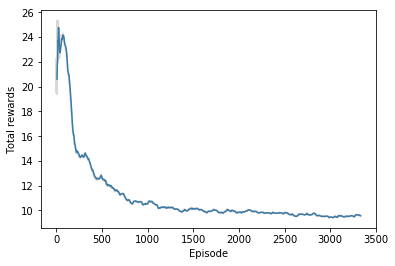

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

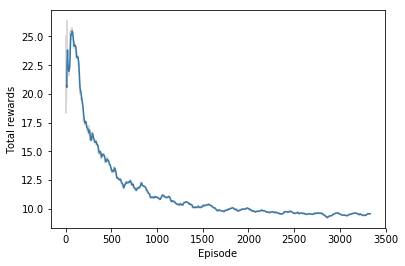

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.